In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/language-detection/Language Detection.csv


# Import libraries

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import cv2
import string
import re
import os
import nltk
import sklearn
import warnings
warnings.filterwarnings('ignore')

# Read the data_set

In [31]:
data_set = pd.read_csv("/kaggle/input/language-detection/Language Detection.csv")
data_set

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English
...,...,...
10332,ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...,Kannada
10333,ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...,Kannada
10334,ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...,Kannada
10335,ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...,Kannada


In [32]:
print("The number of language" ,data_set["Language"].nunique())

The number of language 17


In [33]:
#drop seven language
language_column = "Language"
languages_to_drop = ["Kannada", "Sweedish", "Tamil", "Malayalam", "Greek", "Dutch","Hindi"]
data_set = data_set[~data_set[language_column].isin(languages_to_drop)]
data_set.Language.unique()

array(['English', 'Portugeese', 'French', 'Spanish', 'Russian', 'Danish',
       'Italian', 'Turkish', 'Arabic', 'German'], dtype=object)

In [34]:
print("The number of language" ,data_set["Language"].nunique())

The number of language 10


In [35]:
data_set

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English
...,...,...
9963,narcisa änderte ihre art und weise sie kämpfte...,German
9964,Wie' s Narzissmus jetzt erzählt Marian beiden ...,German
9965,"Hat sie, ich denke, sie würde jetzt kein Goldb...",German
9966,"Terry, du siehst tatsächlich ein bisschen wie ...",German


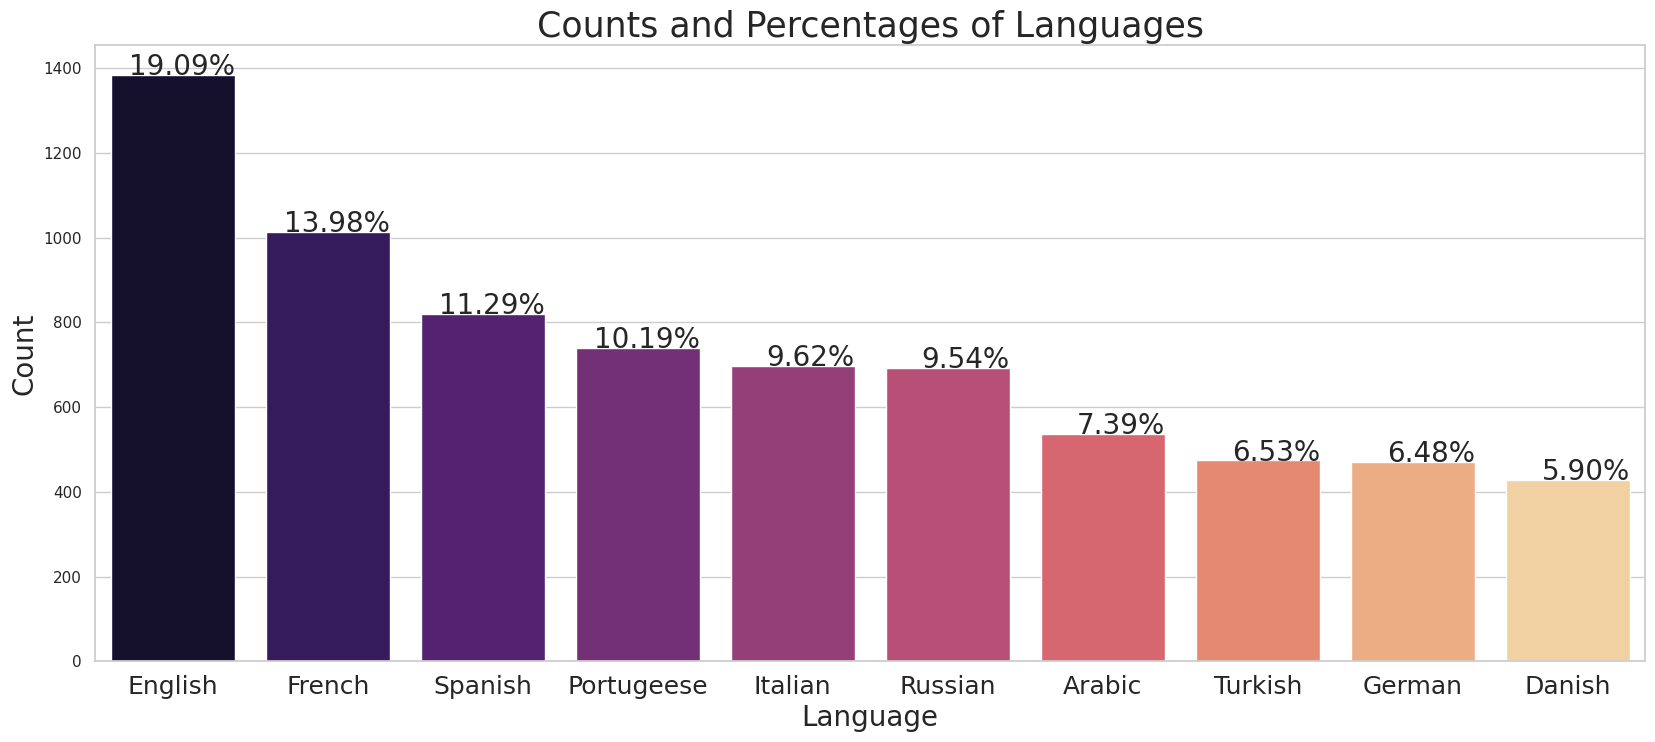

In [37]:
#Info of the data
plt.figure(figsize=(20,8))
total= float(len(data_set['Language']))
ax= sns.countplot(x= 'Language', data= data_set, order= data_set['Language'].value_counts().index, palette= 'magma')
for p in ax.patches:
    percentage= '{:.2f}%'.format(100 * p.get_height()/total)
    x= p.get_x() + p.get_width()
    y= p.get_height()
    ax.annotate(percentage, (x, y), fontsize=20, ha='right')
plt.title('Counts and Percentages of Languages', fontsize=25)
plt.xlabel("Language",fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.xticks(size= 18, rotation=0) 
plt.show()

In [38]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7255 entries, 0 to 9967
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      7255 non-null   object
 1   Language  7255 non-null   object
dtypes: object(2)
memory usage: 170.0+ KB


In [39]:
#convert language to (0,1,2,..)
data_set['Language'] = data_set.Language.replace(to_replace=['English','Portugeese', 'French', 'Spanish', 'Russian', 'Danish',  'Italian', 'Turkish', 'Arabic', 'German'], value=[0,1,2,3,4,5,6,7,8,9])

# Feature Engineering

In [40]:
#Feature Creation
#text lenght
data_set['Text_len'] = data_set['Text'].apply(lambda x: len(x))
data_set.head()

,Text,Language,Text_len
0,"Nature, in the broadest sense, is the natural...",0,85
1,"""Nature"" can refer to the phenomena of the phy...",0,87
2,"The study of nature is a large, if not the onl...",0,65
3,"Although humans are part of nature, human acti...",0,123
4,[1] The word nature is borrowed from the Old F...,0,194


In [41]:
#punctuation %
def punctuation_count(txt):
    count= sum([1 for c in txt if c in string.punctuation])
    return (count / len(txt)) * 100

In [42]:
data_set['Text_punctuation_%'] = data_set['Text'].apply(lambda x: punctuation_count(x))
data_set.head()

,Text,Language,Text_len,Text_punctuation_%
0,"Nature, in the broadest sense, is the natural...",0,85,5.882353
1,"""Nature"" can refer to the phenomena of the phy...",0,87,4.597701
2,"The study of nature is a large, if not the onl...",0,65,4.615385
3,"Although humans are part of nature, human acti...",0,123,1.626016
4,[1] The word nature is borrowed from the Old F...,0,194,5.670103


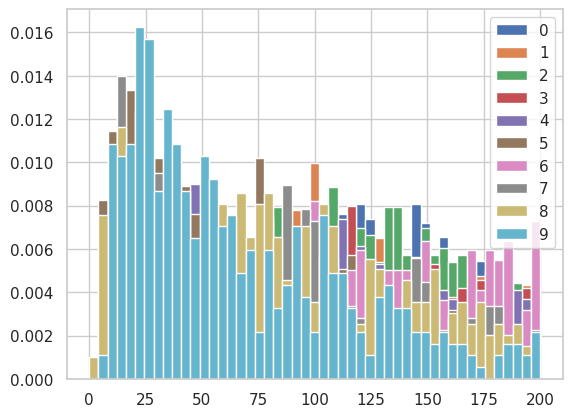

In [43]:
#Feature Evaluation
bins = np.linspace(0,200,50)
pyplot.hist(data_set[data_set['Language']==0]['Text_len'],bins,label=0,density=True)
pyplot.hist(data_set[data_set['Language']==1]['Text_len'],bins,label=1,density=True)
pyplot.hist(data_set[data_set['Language']==2]['Text_len'],bins,label=2,density=True)
pyplot.hist(data_set[data_set['Language']==3]['Text_len'],bins,label=3,density=True)
pyplot.hist(data_set[data_set['Language']==4]['Text_len'],bins,label=4,density=True)
pyplot.hist(data_set[data_set['Language']==5]['Text_len'],bins,label=5,density=True)
pyplot.hist(data_set[data_set['Language']==6]['Text_len'],bins,label=6,density=True)
pyplot.hist(data_set[data_set['Language']==7]['Text_len'],bins,label=7,density=True)
pyplot.hist(data_set[data_set['Language']==8]['Text_len'],bins,label=8,density=True)
pyplot.hist(data_set[data_set['Language']==9]['Text_len'],bins,label=9,density=True)
pyplot.legend(loc = 'upper right')
pyplot.show()

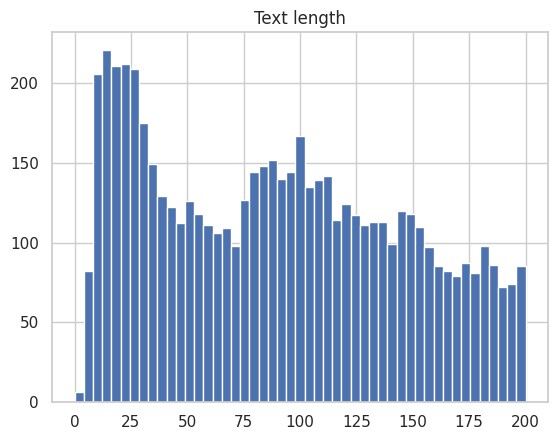

In [44]:
bins = np.linspace(0,200,50)
pyplot.hist(data_set['Text_len'],bins)
pyplot.title("Text length")
pyplot.show()

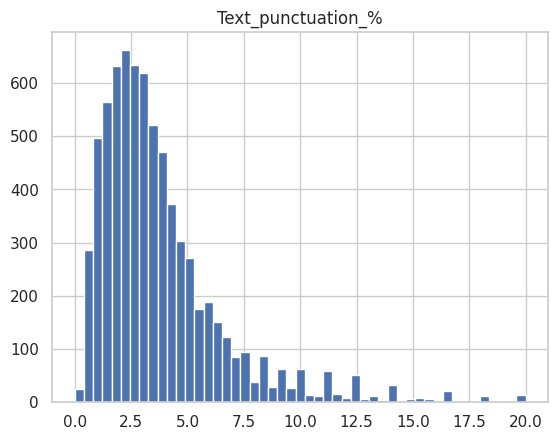

In [46]:
#punctuation count
bins = np.linspace(0,20,50)
pyplot.hist(data_set['Text_punctuation_%'],bins)
pyplot.title("Text_punctuation_%")
pyplot.show()

# Preprocessing

In [47]:
#show stopwords in the dataset
from nltk.corpus import stopwords
print(stopwords.words('english'),stopwords.words('arabic'),
      stopwords.words('spanish'),stopwords.words('french'),
      stopwords.words('portuguese'),stopwords.words('italian'),
      stopwords.words('russian'),stopwords.words('dutch'),
      stopwords.words('turkish'),stopwords.words('german'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [50]:
#Removing stop words with NLTK 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
filtered_sentence1 = []
for x in data_set['Text']:
    stop = []
    stop.append(" ".join(stopwords.words('english')))
    stop.append(" ".join(stopwords.words('arabic')))
    stop.append(" ".join(stopwords.words('spanish')))
    stop.append(" ".join(stopwords.words('french')))
    stop.append(" ".join(stopwords.words('portuguese')))
    stop.append(" ".join(stopwords.words('italian')))
    stop.append(" ".join(stopwords.words('russian')))
    stop.append(" ".join(stopwords.words('dutch')))
    stop.append(" ".join(stopwords.words('turkish')))
    stop.append(" ".join(stopwords.words('german')))
    stop=" ".join(stop)
    stop=word_tokenize(stop)
    word_tokens = word_tokenize(x)
    # converts the words in word_tokens to lower case and then checks whether
    #they are present in stop_words or not
    filtered_sentence = []
    for w in word_tokens:
        if w.lower() not in stop:
            filtered_sentence.append(w.lower())  
    filtered_sentence1.append(' '.join(filtered_sentence))     
data_set['Text']=filtered_sentence1

In [51]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'you',
 "'re",
 'you',
 "'ve",
 'you',
 "'ll",
 'you',
 "'d",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'she',
 "'s",
 'her',
 'hers',
 'herself',
 'it',
 'it',
 "'s",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'that',
 "'ll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'ho

In [52]:
data_set

,Text,Language,Text_len,Text_punctuation_%
0,"nature , broadest sense , natural , physical ,...",0,85,5.882353
1,"`` nature '' refer phenomena physical world , ...",0,87,4.597701
2,"study nature large , , part science .",0,65,4.615385
3,"although humans part nature , human activity o...",0,123,1.626016
4,[ 1 ] word nature borrowed old french nature d...,0,194,5.670103
...,...,...,...,...
9963,"narcisa änderte art weise kämpfte zuerst , lan...",9,200,1.500000
9964,"' narzissmus erzählt marian beiden , passiert ...",9,122,2.459016
9965,", denke , goldbrot mehr , ?",9,68,5.882353
9966,"terry , siehst tatsächlich bisschen engel , se...",9,107,3.738318


In [53]:
#show punctuation in the dataset
from string import punctuation
punctuation = list(punctuation)
print(punctuation)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [54]:
def clean_Text(Text):
    # Convert to lowercase
    Text = Text.lower()

    # Remove special characters and punctuation
    Text = re.sub('[^a-zA-Z0-9\s]', '', Text)

    # Remove numbers
    Text = re.sub('\d+', '', Text)

    # Remove extra whitespace
    Text = re.sub('\s+', ' ', Text).strip()

    return Text

# Apply the clean_text function to the content column
data_set['Text'] = data_set['Text'].apply(clean_Text)

In [55]:
data_set

,Text,Language,Text_len,Text_punctuation_%
0,nature broadest sense natural physical materia...,0,85,5.882353
1,nature refer phenomena physical world life gen...,0,87,4.597701
2,study nature large part science,0,65,4.615385
3,although humans part nature human activity oft...,0,123,1.626016
4,word nature borrowed old french nature derived...,0,194,5.670103
...,...,...,...,...
9963,narcisa nderte art weise kmpfte zuerst langsam...,9,200,1.500000
9964,narzissmus erzhlt marian beiden passiert seit ...,9,122,2.459016
9965,denke goldbrot mehr,9,68,5.882353
9966,terry siehst tatschlich bisschen engel sehe kn...,9,107,3.738318


# The Model

In [57]:
X= data_set["Text"]
y= data_set["Language"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=42)

In [60]:
#TF-IDF Vecorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, analyzer='word',ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.fit_transform(X_test)

In [61]:
#Vector word
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(data_set['Text'])
X_train_count =  count_vect.transform(X_train)
X_test_count =  count_vect.transform(X_test)

In [62]:
# Model: Linear SVM
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier(alpha = 0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_count, y_train)
y_pred = lsvm.predict(X_test_count)
print('lsvm using count vectors accuracy %s' % accuracy_score(y_pred, y_test))

lsvm using count vectors accuracy 0.8682469680264608


In [63]:
all_language = ['English','Portugeese', 'French', 'Spanish', 'Russian', 'Danish',  'Italian', 'Turkish', 'Arabic', 'German']

# Test The modle

In [64]:
x = ['Also lasst uns loslegen, hey, das ist alles und ihr schaut zu.']
X_count =  count_vect.transform(x)
y_pred = lsvm.predict(X_count)
print(y_pred)
print(all_language[y_pred[0]])

[9]
German


In [65]:
x=['Sürekli eklemeler ve değişiklikler yapıldığı için hiçbir zaman tamamlanmayacağı varsayılmaktadır.']
X_count =  count_vect.transform(x)
y_pred = lsvm.predict(X_count)
print(y_pred)
print(all_language[y_pred[0]])

[7]
Turkish


In [66]:
x=['Nature редактируется в Великобритании издательством Nature Publishing Group и издаётся в Лондоне.']
X_count =  count_vect.transform(x)
y_pred = lsvm.predict(X_count)
print(y_pred)
print(all_language[y_pred[0]])

[4]
Russian


In [67]:
x=['Il fattore di impatto (impact factor) di questa rivista supera nel 2014 lenorme valore di 42,352.']
X_count =  count_vect.transform(x)
y_pred = lsvm.predict(X_count)
print(y_pred)
print(all_language[y_pred[0]])

[6]
Italian


In [70]:
x=[' A Nature tem um público on-line de cerca de 3 milhões de leitores únicos por mês.']
X_count =  count_vect.transform(x)
y_pred = lsvm.predict(X_count)
print(y_pred)
print(all_language[y_pred[0]])

[3]
Spanish


# The End